<a href="https://colab.research.google.com/github/lllljjjjllllqqqq/123/blob/main/base_attention%EF%BC%88%E5%89%AF%E6%9C%AC%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue May 18 07:25:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8     8W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/毕设/情感分类

/content/drive/MyDrive/毕设/情感分类


In [ ]:
 
from keras.preprocessing import sequence
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.engine.topology import Layer
import jieba
from sklearn.model_selection import train_test_split 
import json

In [ ]:
max_len=100

In [ ]:
# with open('情感分类测试集/ChnSentiCorp/dev.txt','r',encoding='utf-8') as f:
#   lines=f.readlines()
#   labels=[]
#   sentences=[]
#   for line in lines:
#     [y,x]=line.strip('\n').strip().split('\t')
#     if len(x)>5:
#       labels.append(y)
#       sentences.append(x)
# x=[]
# for line in sentences[1:]:
#   h=jieba.lcut(line,cut_all=False,HMM=True) # 精确模式
#   x.append(h)
def build_map(lists):
    maps = {}
    for line in lists:
        for word in line:
            if word not in maps:
                maps[word] = len(maps)+2   #0:mask 1:未知
    return maps
import json
def write_dict(dic,output_name):
  jsObj = json.dumps(dic)  
  fileObject = open(output_name+'.json', 'w')  
  fileObject.write(jsObj)  
  fileObject.close()  
# vocab=build_map(x)
# write_dict(vocab,'vocab')

# with open('vocab.json','r',encoding='utf8')as fp:
#     vocab = json.load(fp)
# p=word2id(x,vocab)
# vocab=build_map(x)
# len(vocab)

In [ ]:
def word2id(lists,vocab=None):
  ls=[]
  for line in lists:
    l=[]
    for word in line:
      if word in vocab:
        l.append(vocab[word])
      else:
        l.append(1)
    ls.append(l)
  return ls


In [ ]:
def load_data(file_name):
  with open(file_name,'r',encoding='utf-8') as f:
    lines=f.readlines()
    labels=[]
    sentences=[]
    for line in lines:
      [y,x]=line.strip('\n').strip().split('\t')
      if len(x)>5:
        labels.append(y)
        sentences.append(x)
  x=[]
  for line in sentences[1:]:
    h=jieba.lcut(line,cut_all=False,HMM=True) # 精确模式
    x.append(h)
  # x.append(['邓紫棋','拍','出来','的','效果','没有','汤唯','郭采洁','拍','出来','的','有','质感','。'])
  # labels.append('0')
  # vocab=build_map(x)
  # write_dict(vocab,'vocab2')
  with open('vocab2.json','r',encoding='utf8')as fp:
    vocab = json.load(fp)
  p=word2id(x,vocab)
  y=[int(i) for i in labels[1:]]
  p=np.array(p)
  y=np.array(y)
  p=sequence.pad_sequences(p,maxlen=max_len,value=0,padding='post')
  return (p,y)

In [ ]:
(x_train,y_train)=load_data('情感分类测试集/ChnSentiCorp/train.tsv')

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.692 seconds.
Prefix dict has been built successfully.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
y_train.sum()

4797

In [ ]:
(x_test,y_test)=load_data('情感分类测试集/ChnSentiCorp/dev.txt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
with open('vocab2.json','r',encoding='utf8')as fp:
  vocab = json.load(fp)
max_features=len(vocab)+2

In [ ]:
max_features

35098

In [ ]:
 
# from keras.preprocessing import sequence
# from matplotlib import pyplot as plt
# import pandas as pd
# import numpy as np
# import tensorflow as tf
# from keras import backend as K
# from keras.engine.topology import Layer
class Self_Attention(Layer):
 
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Self_Attention, self).__init__(**kwargs)
 
    def build(self, input_shape):
        # 为该层创建一个可训练的权重
        #inputs.shape = (batch_size, time_steps, seq_len)
        self.kernel = self.add_weight(name='kernel',
                                      shape=(3,input_shape[2], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
 
        super(Self_Attention, self).build(input_shape)  # 一定要在最后调用它
 
    def call(self, x):
        mask = padding_mask(x)
        #mask2 = padding_mask(x)

        WQ = K.dot(x, self.kernel[0])
        WK = K.dot(x, self.kernel[1])
        WV = K.dot(x, self.kernel[2])
        WQ = WQ + (1 - mask) * -1e9
        #print("WQ.shape",WQ.shape)
        #print('mask.shape',mask.shape)
        #print("K.permute_dimensions(WK, [0, 2, 1]).shape",K.permute_dimensions(WK, [0, 2, 1]).shape)
        #mask = K.batch_dot(mask,K.permute_dimensions(mask, [0, 2, 1]))
        QK = K.batch_dot(WQ,K.permute_dimensions(WK, [0, 2, 1]))
        #print('mask.shape',mask.shape)
        QK = QK / (self.output_dim**0.5)
 
        QK = K.softmax(QK)#+ (1 - mask) * -1e9)
 #+ (1 - mask) * -1e9
       # print("QK.shape",QK.shape)
 
        V = K.batch_dot(QK,WV)
 
        return V
 
    def compute_output_shape(self, input_shape):
 
        return (input_shape[0],input_shape[1],self.output_dim)

def positional_embedding(maxlen, model_size):
    PE = np.zeros((maxlen, model_size))
    for i in range(maxlen):
        for j in range(model_size):
            if j % 2 == 0:
                PE[i, j] = np.sin(i / 10000 ** (j / model_size))
            else:
                PE[i, j] = np.cos(i / 10000 ** ((j-1) / model_size))
    PE = tf.constant(PE, dtype=tf.float32)
    return PE

def padding_mask(seq):
    mask = tf.cast(tf.math.not_equal(seq, 0), dtype=tf.float32)
    mask = mask[:,:]
    return mask


In [ ]:
batch_size = 64
from keras.models import Model
from keras.layers import *
from keras.optimizers import RMSprop
from keras.optimizers import SGD,Adam

In [ ]:
S_inputs = Input(shape=(max_len,), dtype='int32')
 
embeddings = Embedding(max_features, 256,mask_zero=True)(S_inputs)
#pos_embedding = positional_embedding(max_len, 256)
#pos_embedding = pos_embedding + (1 - embeddings) * -1e9
emb=embeddings#+pos_embedding
 
O_seq = Self_Attention(256)(emb)
O_seq = Flatten()(O_seq)
 
# O_seq = GlobalAveragePooling1D()(O_seq)
 
#O_seq = Dropout(0.3)(O_seq)
 
outputs = Dense(1,activation='sigmoid')(O_seq)
 
 
model = Model(inputs=S_inputs, outputs=outputs)
 
print(model.summary())
# try using different optimizers and different optimizer configs
#opt = Adam(lr=0.0002,decay=0.00001)
#loss = 'categorical_crossentropy'
loss='binary_crossentropy',
model.compile(loss=loss,
             #optimizer=opt,
              optimizer=Adam(lr=0.0005,decay=0.00001),
              #RMSprop(lr=1e-3),
             metrics=['acc'])
#%%
print('Train...')
 
h = model.fit(x_train, y_train,
 
         batch_size=batch_size,
 
         epochs=5,
 
         validation_data=(x_test, y_test))
 
# plt.plot(h.history["loss"],label="train_loss")
# plt.plot(h.history["val_loss"],label="val_loss")
# plt.plot(h.history["acc"],label="train_acc")
# plt.plot(h.history["val_acc"],label="val_acc")
# plt.legend()
# plt.show()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 256)          8985088   
_________________________________________________________________
self__attention (Self_Attent (None, 100, 256)          196608    
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25601     
Total params: 9,207,297
Trainable params: 9,207,297
Non-trainable params: 0
_________________________________________________________________
None
Train...
Epoch 1/5
150/150 [==============================] - 16s 99ms/step - loss: 0.5930 - acc: 0.6691 - val_l

In [ ]:
# from keras.utils import plot_model
# plot_model(model, 'model.png', show_shapes=True)


In [ ]:
h=jieba.lcut('邓紫棋拍出来的效果没有汤唯郭采洁拍出来的有质感。',cut_all=False,HMM=True) # 精确模式
h=[['邓紫棋','拍','出来','的','效果','没有','汤唯','郭采洁','拍','出来','的','有','质感','。']]
# -0.4809237 -0.782549 0.49979883 -0.040339828 0.6633401 -0.52321875 -0.53521717 -0.42850167 -0.80775726 0.45727575 -0.041058272 0.13017127 0.8416828 0.032216348
# 邓紫棋    拍      出来    的     效果    没有    汤唯    郭采洁      拍      出来    的     有    质感   。
-0.03182719 -0.31185108 0.36503768 0.07232723  0.5126569  -0.4544415 0.055527195 0.0261359  -0.3133937  0.35460818  0.07373014 0.18920526 0.8381199 0.045788333
with open('vocab2.json','r',encoding='utf8')as fp:
  vocab = json.load(fp)
p2=word2id(h,vocab)
p2=sequence.pad_sequences(p2,maxlen=max_len,value=0,padding='post')

In [ ]:
p2

array([[35095,  2442,   197,     5,  1085,    80, 35096, 35097,  2442,
          197,     5,    10,  3728,    24,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)

In [ ]:
from keras.models import Model
#生成函数模型
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer('flatten').output)
#导出中间结果
conv1d_1=intermediate_layer_model.predict(p2[0])


In [ ]:
conv1d_1.reshape(-1).shape

(25600,)

In [ ]:
weight_Dense_1,bias_Dense_1 = model.get_layer('dense').get_weights()

In [ ]:
weight_Dense_1.reshape(-1)

array([-0.02437959, -0.03047802,  0.01998975, ..., -0.03030578,
       -0.03752842, -0.00775602], dtype=float32)

In [ ]:
w=conv1d_1.reshape(-1) * weight_Dense_1.reshape(-1)+bias_Dense_1/len(conv1d_1.reshape(-1))

In [ ]:
bias_Dense_1

array([0.00474976], dtype=float32)

In [ ]:
y_test[2]

0

In [ ]:
w.sum()

2.3909829

In [ ]:
for i in range(0,100):
  print(w[i*256:i*256+257].sum())

-0.03182719
-0.31185108
0.36503768
0.07232723
0.5126569
-0.4544415
0.055527195
0.0261359
-0.3133937
0.35460818
0.07373014
0.18920526
0.8381199
0.045788333
0.008700754
0.008661101
0.005637884
0.008042234
0.008851418
0.0076372353
0.008167677
0.007977117
0.007423453
0.007997379
0.009137785
0.008123668
0.007670063
0.0074045244
0.008623829
0.010667156
0.008370696
0.009362826
0.011317097
0.010373455
0.007916627
0.009030974
0.009870576
0.007675258
0.009844211
0.010117047
0.009309542
0.011335649
0.01130927
0.009279933
0.010920279
0.009648271
0.010051237
0.009596217
0.010706458
0.010289893
0.010153452
0.011151196
0.008858692
0.010625934
0.0107132355
0.012635457
0.010289278
0.011834966
0.011426076
0.011965586
0.011161752
0.012899565
0.013055753
0.011821324
0.011702843
0.012093326
0.011739769
0.013003042
0.011695923
0.013311852
0.012277925
0.013232734
0.012938099
0.0133591555
0.014805467
0.0144646475
0.015348898
0.014969039
0.014006568
0.015526514
0.0145348245
0.0148444865
0.014779536
0.01440784




```
# 此内容为代码格式
WQ.shape (None, 64, 128)
K.permute_dimensions(WK, [0, 2, 1]).shape (None, 128, 64)
QK.shape (None, 64, 64)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 64, 128)           2560000   
_________________________________________________________________
self__attention (Self_Attent (None, 64, 128)           49152     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
=================================================================
Total params: 2,609,410
Trainable params: 2,609,410
Non-trainable params: 0
_________________________________________________________________
None
Train...
Epoch 1/10
WQ.shape (None, 64, 128)
K.permute_dimensions(WK, [0, 2, 1]).shape (None, 128, 64)
QK.shape (None, 64, 64)
WQ.shape (None, 64, 128)
K.permute_dimensions(WK, [0, 2, 1]).shape (None, 128, 64)
QK.shape (None, 64, 64)
782/782 [==============================] - ETA: 0s - loss: 0.6235 - accuracy: 0.6616WQ.shape (None, 64, 128)
K.permute_dimensions(WK, [0, 2, 1]).shape (None, 128, 64)
QK.shape (None, 64, 64)
782/782 [==============================] - 25s 28ms/step - loss: 0.6233 - accuracy: 0.6617 - val_loss: 0.3807 - val_accuracy: 0.8283
Epoch 2/10
782/782 [==============================] - 21s 27ms/step - loss: 0.3232 - accuracy: 0.8624 - val_loss: 0.3677 - val_accuracy: 0.8372
Epoch 3/10
782/782 [==============================] - 21s 27ms/step - loss: 0.2571 - accuracy: 0.8963 - val_loss: 0.3917 - val_accuracy: 0.8314
Epoch 4/10
782/782 [==============================] - 21s 27ms/step - loss: 0.2053 - accuracy: 0.9205 - val_loss: 0.4486 - val_accuracy: 0.8200
Epoch 5/10
782/782 [==============================] - 21s 27ms/step - loss: 0.1548 - accuracy: 0.9430 - val_loss: 0.5307 - val_accuracy: 0.8102
Epoch 6/10
782/782 [==============================] - 22s 28ms/step - loss: 0.1164 - accuracy: 0.9587 - val_loss: 0.6609 - val_accuracy: 0.8021
Epoch 7/10
782/782 [==============================] - 22s 28ms/step - loss: 0.0866 - accuracy: 0.9714 - val_loss: 0.8120 - val_accuracy: 0.7927
Epoch 8/10
782/782 [==============================] - 21s 27ms/step - loss: 0.0590 - accuracy: 0.9824 - val_loss: 1.0130 - val_accuracy: 0.7826
Epoch 9/10
782/782 [==============================] - 21s 27ms/step - loss: 0.0394 - accuracy: 0.9909 - val_loss: 1.2482 - val_accuracy: 0.7773
Epoch 10/10
782/782 [==============================] - 21s 26ms/step - loss: 0.0286 - accuracy: 0.9933 - val_loss: 1.5077 - val_accuracy: 0.7754
```
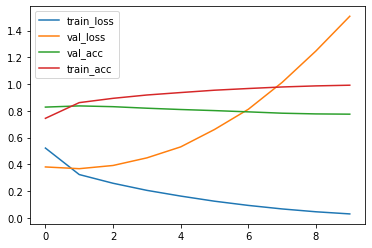

